# Waste Clssifier Image Classification Model


## 1. Loading Data

In [10]:
!pip install torch
!pip install torchvision
!pip install kagglehub


In [11]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [14]:
class GarbageDataset(Dataset):
    def __init__(self, root, transform=None):

        self.root = root
        self.transform = transform

        # Get all class folders
        self.classes = sorted([d for d in os.listdir(root)
                              if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Build list of (image_path, label) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
import kagglehub
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

print("\nContents of dataset directory:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/ - {len(os.listdir(item_path))} items")
    else:
        print(f"📄 {item}")

# Check one level deeper
print("\nLooking deeper:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for subitem in os.listdir(item_path)[:5]:  # Show first 5 items
            print(f"  {item}/{subitem}")

Path to dataset files: C:\Users\sunny\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5

Contents of dataset directory:
📁 Garbage_Dataset_Classification/ - 2 items

Looking deeper:
  Garbage_Dataset_Classification/images
  Garbage_Dataset_Classification/metadata.csv


In [16]:
import random

dataset_path = os.path.join(path, "Garbage_Dataset_Classification", "images")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = GarbageDataset(
    root=dataset_path,
    transform=transform
)
# Randomly sample 1% of dataset
num_samples = int(len(full_dataset) * 0.01)
indices = random.sample(range(len(full_dataset)), num_samples)

# Get corresponding labels
labels = [full_dataset.samples[i][1] for i in indices]

# Split 80/20 train/test with stratification
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_data = Subset(full_dataset, train_indices)
test_data = Subset(full_dataset, test_indices)

print(f"Total samples: {len(full_dataset)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {full_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# get the length of the output:
print(f"Output length: {len(full_dataset.classes)}")

Total samples: 13901
Train samples: 111
Test samples: 28
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Output length: 6


## 2. Visualizing the data

Image shape: torch.Size([3, 224, 224])


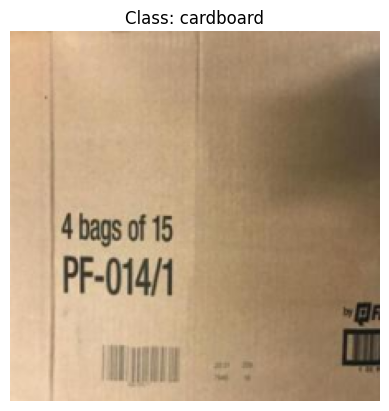

In [17]:
image,label = train_data[8]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

## 3. Creating the Model

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

This model uses Convolutional Nerual Networks to classify images

In [19]:
class WasteClassifierModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

In [20]:
torch.manual_seed(42)
model_1 = WasteClassifierModelV1(input_shape=3, hidden_units=64, output_shape=len(full_dataset.classes)).to(device)
model_1

WasteClassifierModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### setting up loss function and optimizer

In [21]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [22]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [23]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Training model

In [24]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [25]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []
# Measure time
train_time_start_model_1 = timer()

# Train and test model
epochs = 30
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader ,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_loader ,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.78834 | Train accuracy: 24.95%


  3%|▎         | 1/30 [00:18<09:00, 18.65s/it]

Test loss: 1.78856 | Test accuracy: 21.43%

Epoch: 1
---------
Train loss: 1.78943 | Train accuracy: 21.41%


  7%|▋         | 2/30 [00:35<08:11, 17.54s/it]

Test loss: 1.78556 | Test accuracy: 21.43%

Epoch: 2
---------
Train loss: 1.77443 | Train accuracy: 23.18%


 10%|█         | 3/30 [00:51<07:38, 16.99s/it]

Test loss: 1.77898 | Test accuracy: 21.43%

Epoch: 3
---------
Train loss: 1.77733 | Train accuracy: 22.29%


 13%|█▎        | 4/30 [01:07<07:12, 16.63s/it]

Test loss: 1.77486 | Test accuracy: 21.43%

Epoch: 4
---------
Train loss: 1.80754 | Train accuracy: 20.52%


 17%|█▋        | 5/30 [01:24<06:54, 16.57s/it]

Test loss: 1.77319 | Test accuracy: 21.43%

Epoch: 5
---------
Train loss: 1.80193 | Train accuracy: 16.51%


 20%|██        | 6/30 [01:40<06:34, 16.46s/it]

Test loss: 1.78955 | Test accuracy: 10.71%

Epoch: 6
---------
Train loss: 1.74778 | Train accuracy: 27.76%


 23%|██▎       | 7/30 [01:58<06:29, 16.95s/it]

Test loss: 1.77860 | Test accuracy: 14.29%

Epoch: 7
---------
Train loss: 1.71859 | Train accuracy: 25.31%


 27%|██▋       | 8/30 [02:17<06:26, 17.56s/it]

Test loss: 1.79860 | Test accuracy: 10.71%

Epoch: 8
---------
Train loss: 1.71187 | Train accuracy: 27.66%


 30%|███       | 9/30 [02:33<06:00, 17.18s/it]

Test loss: 1.88023 | Test accuracy: 10.71%

Epoch: 9
---------
Train loss: 1.67508 | Train accuracy: 32.86%


 33%|███▎      | 10/30 [02:52<05:53, 17.67s/it]

Test loss: 1.91754 | Test accuracy: 10.71%

Epoch: 10
---------
Train loss: 1.68476 | Train accuracy: 26.20%


 37%|███▋      | 11/30 [03:11<05:41, 17.95s/it]

Test loss: 1.88236 | Test accuracy: 14.29%

Epoch: 11
---------
Train loss: 1.71690 | Train accuracy: 29.43%


 40%|████      | 12/30 [03:29<05:24, 18.03s/it]

Test loss: 1.81182 | Test accuracy: 17.86%

Epoch: 12
---------
Train loss: 1.71874 | Train accuracy: 19.74%


 43%|████▎     | 13/30 [03:48<05:13, 18.45s/it]

Test loss: 1.81204 | Test accuracy: 21.43%

Epoch: 13
---------
Train loss: 1.63864 | Train accuracy: 27.86%


 47%|████▋     | 14/30 [04:07<04:57, 18.58s/it]

Test loss: 1.92915 | Test accuracy: 14.29%

Epoch: 14
---------
Train loss: 1.67975 | Train accuracy: 31.67%


 50%|█████     | 15/30 [04:26<04:39, 18.66s/it]

Test loss: 1.80960 | Test accuracy: 10.71%

Epoch: 15
---------
Train loss: 1.66263 | Train accuracy: 27.76%


 53%|█████▎    | 16/30 [04:45<04:22, 18.73s/it]

Test loss: 1.77572 | Test accuracy: 17.86%

Epoch: 16
---------
Train loss: 1.66801 | Train accuracy: 30.99%


 57%|█████▋    | 17/30 [05:04<04:03, 18.76s/it]

Test loss: 1.83376 | Test accuracy: 14.29%

Epoch: 17
---------
Train loss: 1.62604 | Train accuracy: 32.66%


 60%|██████    | 18/30 [05:22<03:45, 18.78s/it]

Test loss: 1.91991 | Test accuracy: 14.29%

Epoch: 18
---------
Train loss: 1.58927 | Train accuracy: 31.88%


 63%|██████▎   | 19/30 [05:41<03:27, 18.82s/it]

Test loss: 1.95096 | Test accuracy: 14.29%

Epoch: 19
---------
Train loss: 1.61253 | Train accuracy: 30.21%


 67%|██████▋   | 20/30 [06:00<03:07, 18.80s/it]

Test loss: 2.00122 | Test accuracy: 10.71%

Epoch: 20
---------
Train loss: 1.64797 | Train accuracy: 28.54%


 70%|███████   | 21/30 [06:19<02:48, 18.78s/it]

Test loss: 1.90438 | Test accuracy: 10.71%

Epoch: 21
---------
Train loss: 1.59398 | Train accuracy: 30.10%


 73%|███████▎  | 22/30 [06:37<02:29, 18.72s/it]

Test loss: 1.95093 | Test accuracy: 21.43%

Epoch: 22
---------
Train loss: 1.61548 | Train accuracy: 25.10%


 77%|███████▋  | 23/30 [06:56<02:11, 18.75s/it]

Test loss: 1.85350 | Test accuracy: 14.29%

Epoch: 23
---------
Train loss: 1.58546 | Train accuracy: 32.45%


 80%|████████  | 24/30 [07:15<01:52, 18.82s/it]

Test loss: 1.88616 | Test accuracy: 14.29%

Epoch: 24
---------
Train loss: 1.62522 | Train accuracy: 33.54%


 83%|████████▎ | 25/30 [07:34<01:34, 18.83s/it]

Test loss: 2.03392 | Test accuracy: 10.71%

Epoch: 25
---------
Train loss: 1.63291 | Train accuracy: 32.45%


 87%|████████▋ | 26/30 [07:53<01:14, 18.74s/it]

Test loss: 1.86956 | Test accuracy: 14.29%

Epoch: 26
---------
Train loss: 1.63197 | Train accuracy: 24.32%


 90%|█████████ | 27/30 [08:11<00:56, 18.72s/it]

Test loss: 1.97091 | Test accuracy: 10.71%

Epoch: 27
---------
Train loss: 1.58553 | Train accuracy: 30.10%


 93%|█████████▎| 28/30 [08:30<00:37, 18.64s/it]

Test loss: 1.87909 | Test accuracy: 14.29%

Epoch: 28
---------
Train loss: 1.55864 | Train accuracy: 32.55%


 97%|█████████▋| 29/30 [08:48<00:18, 18.58s/it]

Test loss: 1.88663 | Test accuracy: 14.29%

Epoch: 29
---------
Train loss: 1.52145 | Train accuracy: 34.32%


100%|██████████| 30/30 [09:06<00:00, 18.22s/it]

Test loss: 1.96857 | Test accuracy: 14.29%

Train time on cpu: 546.558 seconds


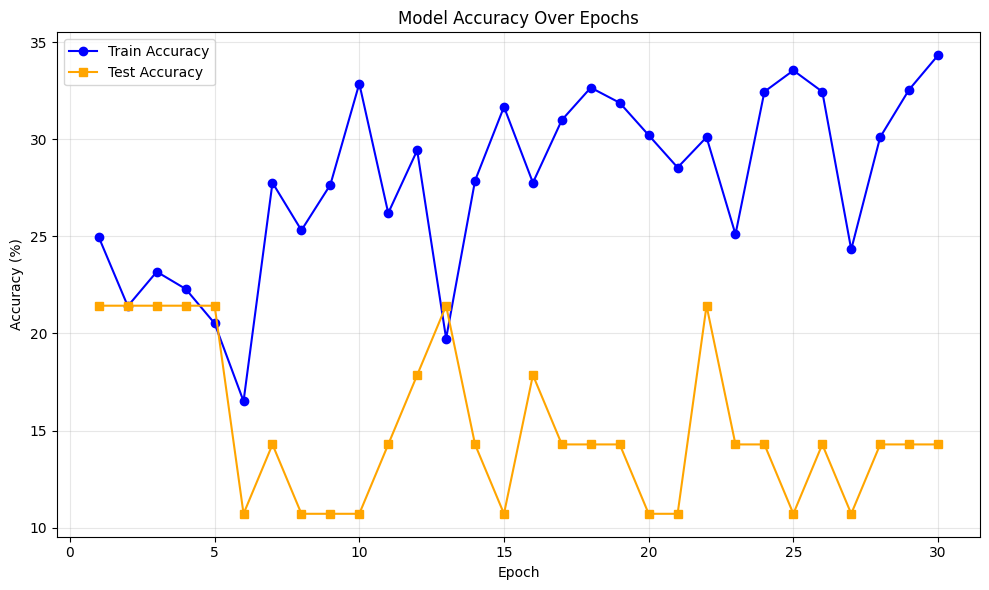

In [26]:
def plot_accuracy_curve(train_accuracies, test_accuracies, epochs):
    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epoch_range, test_accuracies, label='Test Accuracy', marker='s', color='orange')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_accuracy_curve(train_accuracies, test_accuracies, epochs)

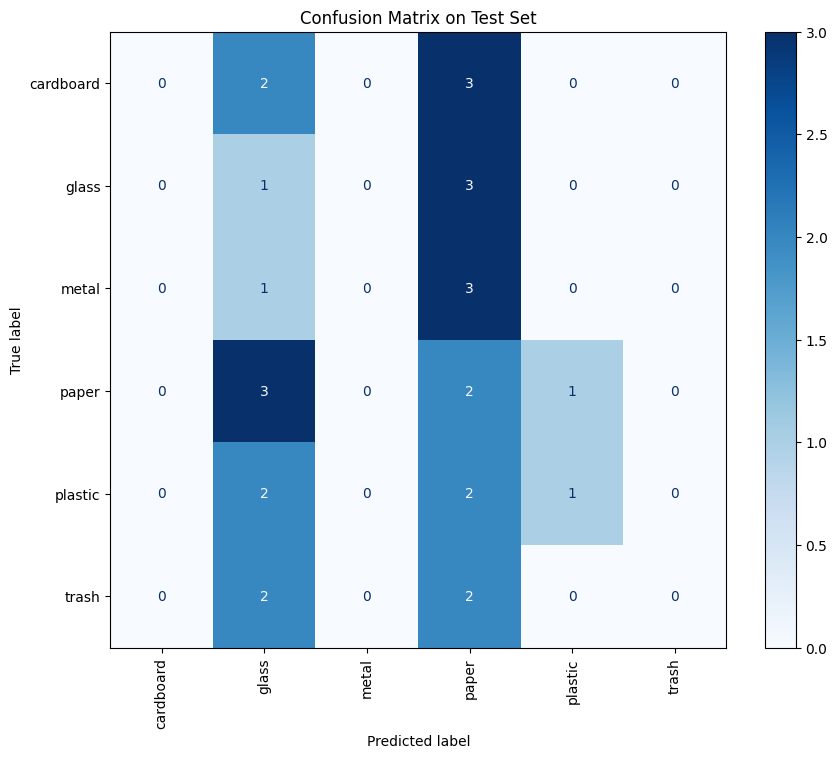

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00         5
       glass       0.09      0.25      0.13         4
       metal       0.00      0.00      0.00         4
       paper       0.13      0.33      0.19         6
     plastic       0.50      0.20      0.29         5
       trash       0.00      0.00      0.00         4

    accuracy                           0.14        28
   macro avg       0.12      0.13      0.10        28
weighted avg       0.13      0.14      0.11        28



c:\Users\sunny\miniconda3\envs\a3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sunny\miniconda3\envs\a3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sunny\miniconda3\envs\a3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Run model on test set and collect predictions
model_1.to(device)
model_1.eval()
all_preds = []
all_labels = []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model_1(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(y.cpu().numpy().tolist())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix on Test Set')
plt.show()

print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

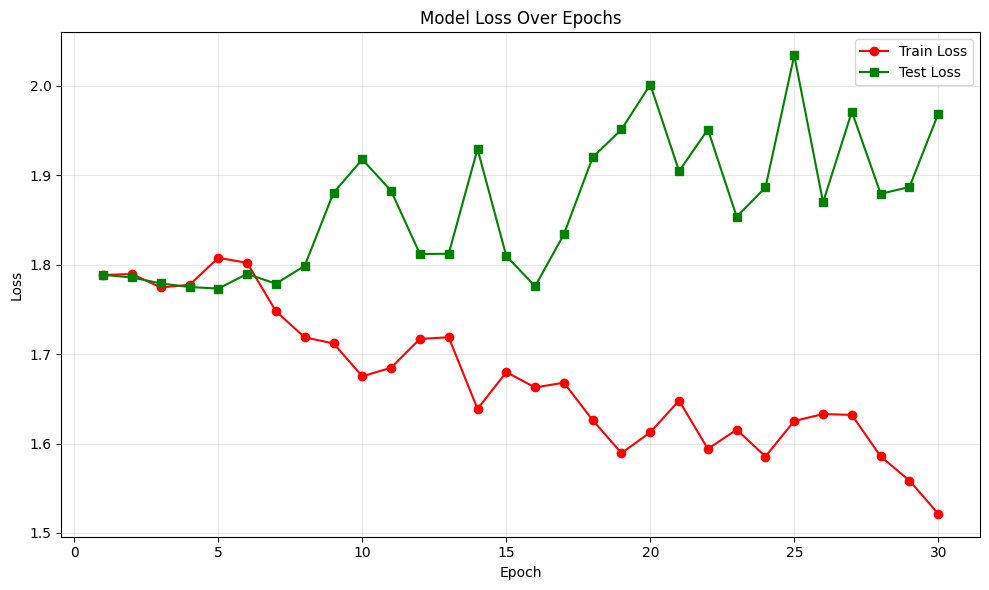

In [28]:
def plot_loss_curve(train_losses, test_losses, epochs):

    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    # Convert tensors to CPU if needed
    train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
    test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
    
    plt.plot(epoch_range, train_losses_cpu, label='Train Loss', marker='o', color='red')
    plt.plot(epoch_range, test_losses_cpu, label='Test Loss', marker='s', color='green')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function with your stored losses
plot_loss_curve(train_losses, test_losses, epochs)

In [29]:

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("GPU NOT detected!")

PyTorch version: 2.9.0+cpu
CUDA available: False
CUDA version: None
GPU NOT detected!
